# Libraries

In [20]:
from datasets import *
from train import *
from torchvision import datasets, transforms, models
from matplotlib.pyplot import figure

# Init Models

In [6]:
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
model64 = models.mobilenet_v3_large()
model64.load_state_dict(torch.load("best_modelsv3/best_batch_i1081020.pth")['model_state_dict'])
model64.to('cuda')
model.eval()
model64.eval()

activationT = {}
activationS = {}
def get_activationT(name):
    def hook(model, input, output):
        activationT[name] = output.detach()
    return hook
def get_activationS(name):
    def hook(model, input, output):
        activationS[name] = output.detach()
    return hook

model.classifier[0].register_forward_hook(get_activationT('emb'))
model64.classifier[0].register_forward_hook(get_activationS('emb'))

# Init Datasets

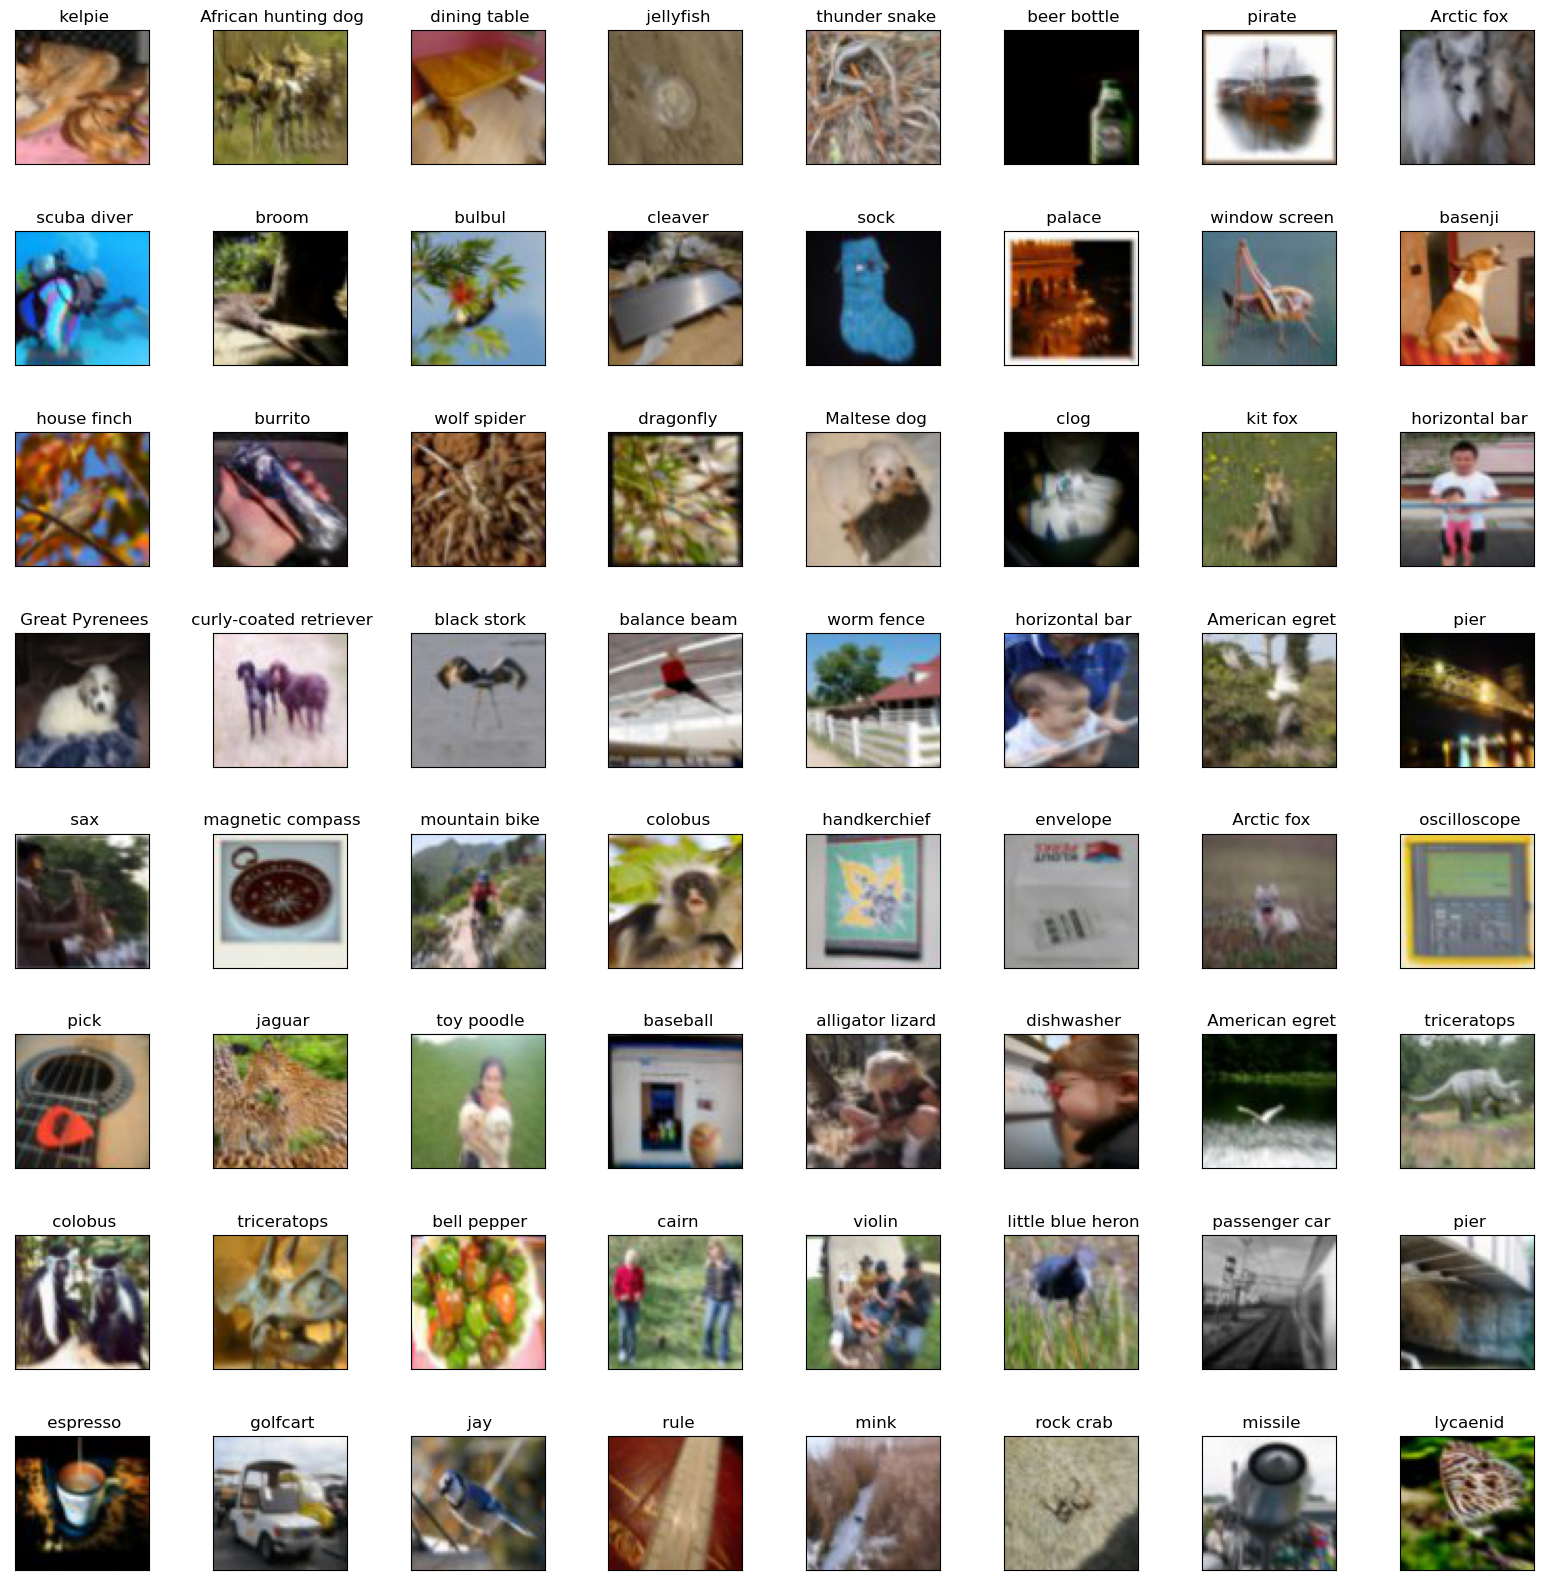

In [14]:
# rand_classes = torch.randperm(1000)[:10]
clean_val_loader,_ = load_imagenet(256,1234,True)
clean_val_loader64,_ = load_imagenet64(256,1234,True)

corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']

corr_val_loaders = []
corr_val_loaders64 = []
for corr in corruptions:
    corr_val_loaders.append(load_imagenetc_val(128,1234,corr,severity=1,shuffle=True))
    corr_val_loaders64.append(load_imagenetc64_val(128,1234,corr,severity=1,shuffle=True))
visualize_batch(corr_val_loaders64[6])

# Set the data ordering

In [15]:
from torch.utils.data import Subset

from torch.utils.data.sampler import Sampler

class CustomOrder(Sampler):
    def __init__(self, dataset):
        self.order = torch.randperm(len(dataset),)
        
    def __iter__(self):
        return iter(self.order)
    
    def __len__(self):
        return len(self.order)

rand_order = CustomOrder(clean_val_loader.dataset)
rand_corr_order = torch.randperm(15)

In [19]:
len(clean_val_loader.dataset)

1153050

# Online distance

In [17]:
num_imgs = 0
transition_points = [1999]
corr_idx = 0
corr_img_count = 0
idxs = []
distances = torch.zeros(50000)


for sample_idx in tqdm(rand_order):
    # corruptions start after the first 500 images
    if num_imgs-1 > 1999:
        # each corruption lasts 3300 images
        if corr_img_count == 3200:
            corr_idx += 1
            corr_img_count = 0
            transition_points.append(num_imgs)
        # get the image at the specified index
        img,target = corr_val_loaders[rand_corr_order[corr_idx]].dataset[sample_idx]
        img64,target64 = corr_val_loaders64[rand_corr_order[corr_idx]].dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
        corr_img_count += 1
    else:
        img,target = clean_val_loader.dataset[sample_idx]
        img64,target64 = clean_val_loader64.dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')

    num_imgs += 1
    

    # get the embedding
    model64(img64.unsqueeze(0))
    model64_emb = activationS['emb'].to('cpu')

    model(img.unsqueeze(0))
    model_emb = activationT['emb'].to('cpu')

    distances[num_imgs-1] = (model_emb-model64_emb).pow(2).sqrt()

    
    idxs.append(num_imgs)

  0%|          | 0/1153050 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1b738c0430>
Traceback (most recent call last):
  File "/home/gc28692/anaconda3/envs/cl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/gc28692/anaconda3/envs/cl/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/gc28692/anaconda3/envs/cl/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/gc28692/anaconda3/envs/cl/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/gc28692/anaconda3/envs/cl/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/home/gc28692/anaconda3/envs/cl/lib/python3.9/selectors.py", li

RuntimeError: expand(torch.FloatTensor{[1280]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)